<a href="https://colab.research.google.com/github/edwarddramirez/taxi-forecast/blob/main/scratch/Naz_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/taxi_colab', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [ ]:
#!ls "/content/mnt/My Drive"

 2020_BUSYDAIS_Client_Client_Copy_Return_1120S.pdf  'Nazanin Komeilizadeh_resume (1).pdf'
'Capstone 2.gdoc'				    'Nazanin Komeilizadeh_resume.pdf'
'Colab Notebooks'				     questions.pdf
'Getting started.pdf'				     SecureMessageAtt.html
 Insight_DS.LA_Acceptance_Letter_19B.pdf	     taxi_colab
 Komeilizadeh_CoC.pdf				     yellow_tripdata_2022-01.parquet
 NazaninKomeilizadeh_2022.pdf


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.1+cu121


In [ ]:
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns

In [ ]:
import torch_geometric
import torch_geometric_temporal

In [ ]:
!pip install libpysal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.8 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import networkx as nx
import libpysal as lp
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd


In [ ]:
df_y = pd.read_csv('/content/mnt/MyDrive/taxi_colab/test.csv')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_y.head()

,Unnamed: 0,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [ ]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066718 entries, 0 to 3066717
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   VendorID               int64  
 2   pickup_datetime        object 
 3   dropoff_datetime       object 
 4   passenger_count        float64
 5   trip_distance          float64
 6   RatecodeID             float64
 7   store_and_fwd_flag     object 
 8   PULocationID           int64  
 9   DOLocationID           int64  
 10  payment_type           int64  
 11  fare_amount            float64
 12  extra                  float64
 13  mta_tax                float64
 14  tip_amount             float64
 15  tolls_amount           float64
 16  improvement_surcharge  float64
 17  total_amount           float64
 18  congestion_surcharge   float64
 19  airport_fee            float64
dtypes: float64(12), int64(5), object(3)
memory usage: 467.9+ MB


In [ ]:
# we have 261 DO locations overall
df_y['DOLocationID'].nunique()

261

In [ ]:
df_y['PULocationID'].isna().sum()

0

In [ ]:
df_y['DOLocationID'].isna().sum()

0

In [ ]:
df_y.VendorID.unique()

array([2, 1])

In [ ]:
df_y.RatecodeID.unique()

array([ 1.,  2.,  4., 99.,  5.,  3.,  6., nan])

In [ ]:
cols_to_drop = ["Unnamed: 0", "VendorID", "store_and_fwd_flag", "extra", "mta_tax",
                "improvement_surcharge", "tip_amount", "tolls_amount", "fare_amount", "airport_fee"]
# RateCodeID (I need to check to see if Manhattan has only one code; if so, drop it)
df_y.dropna(inplace=True)
df_y.drop(cols_to_drop, axis=1, inplace=True)
df_y.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,161,141,2,14.30,2.5
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,43,237,1,16.90,2.5
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,48,238,1,34.90,2.5
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,138,7,1,20.85,0.0
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,107,79,1,19.68,2.5


In [ ]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994975 entries, 0 to 2994974
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   pickup_datetime       object 
 1   dropoff_datetime      object 
 2   passenger_count       float64
 3   trip_distance         float64
 4   RatecodeID            float64
 5   PULocationID          int64  
 6   DOLocationID          int64  
 7   payment_type          int64  
 8   total_amount          float64
 9   congestion_surcharge  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 251.3+ MB


In [ ]:
# number of PU locations
df_y['PULocationID'].nunique()

256

In [ ]:
# 2648099 rows for only MH area
df_y[df_y['PULocationID'].isin([4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
       236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]) ]

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,161,141,2,14.30,2.5
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,43,237,1,16.90,2.5
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,48,238,1,34.90,2.5
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,107,79,1,19.68,2.5
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,161,137,1,27.80,2.5
...,...,...,...,...,...,...,...,...,...,...
2994966,2023-01-31 23:09:30,2023-01-31 23:19:28,2.0,1.74,1.0,113,68,1,19.68,2.5
2994971,2023-01-31 23:14:38,2023-01-31 23:25:30,1.0,3.37,1.0,263,107,1,22.60,2.5
2994972,2023-01-31 23:44:51,2023-01-31 23:58:45,1.0,2.86,1.0,79,246,1,23.30,2.5
2994973,2023-01-31 23:45:00,2023-01-31 23:55:46,2.0,3.80,1.0,68,238,1,25.20,2.5


In [ ]:
# list of Manhattan zones that we kept:
# [ 4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
#         79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
#        137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
#        164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
#        236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]

In [ ]:
condition_1 = (df_y['PULocationID'].isin([4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
       236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]))

In [ ]:
condition_2 = (df_y['DOLocationID'].isin([4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
       236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]))

In [ ]:
df_y_MH = df_y[condition_1 & condition_2 ]

In [ ]:
df_y_MH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2481683 entries, 0 to 2994974
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   pickup_datetime       object 
 1   dropoff_datetime      object 
 2   passenger_count       float64
 3   trip_distance         float64
 4   RatecodeID            float64
 5   PULocationID          int64  
 6   DOLocationID          int64  
 7   payment_type          int64  
 8   total_amount          float64
 9   congestion_surcharge  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 208.3+ MB


In [ ]:
# 513292 were excluded from the dataset
2994975 - 2481683

513292

In [ ]:
df_y_MH.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,161,141,2,14.30,2.5
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,43,237,1,16.90,2.5
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,48,238,1,34.90,2.5
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,107,79,1,19.68,2.5
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,161,137,1,27.80,2.5


In [ ]:
df_y_MH.shape

(2481683, 10)

In [ ]:
df_y_MH['pickup_datetime'].min()

'2023-01-01 00:00:05'

In [ ]:
df_y_MH['pickup_datetime'].max()

'2023-01-31 23:59:59'

In [ ]:
df_y_MH['RatecodeID'].unique()

array([ 1.,  2.,  5., 99.,  3.,  6.,  4.])

In [ ]:
df_y_MH['RatecodeID'].value_counts()

1.0     2469814
5.0        5513
2.0        4607
99.0        984
3.0         715
4.0          47
6.0           3
Name: RatecodeID, dtype: int64

In [ ]:
df_y_MH['payment_type'].unique()

array([2, 1, 4, 3])

In [ ]:
df_y_MH['payment_type'].isna().sum()

0

In [ ]:

df_y_MH['congestion_surcharge'].unique()

array([ 2.5,  0. , -2.5])

In [ ]:
df_y_MH['congestion_surcharge'].value_counts()

 2.5    2419572
 0.0      44837
-2.5      17274
Name: congestion_surcharge, dtype: int64

In [ ]:
df_y_MH.isna().sum()

pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
RatecodeID              0
PULocationID            0
DOLocationID            0
payment_type            0
total_amount            0
congestion_surcharge    0
dtype: int64

In [ ]:
locations = df_y_MH['PULocationID'].unique()

In [ ]:
locations

array([161,  43,  48, 107, 239, 164, 141, 234,  79,  90, 237, 143, 137,
       163,  68, 263, 170, 233, 236, 144, 229, 249, 162, 224, 142, 151,
       211, 148, 238, 231,  13, 262,  75, 125, 186, 158, 246,  50,   4,
        87, 114,  24, 166,  41, 113, 140,  74,  88, 232, 261,  45, 116,
       209, 243, 100, 244,  42,  12, 230, 152, 127, 128, 120])

In [ ]:
len(locations)
# 63 pickup location taxi zones

63

In [ ]:
new_ids = list(range(len(df_y_MH['PULocationID'].unique())))
zip(locations, new_ids)
dict(zip(locations, new_ids))

{161: 0,
 43: 1,
 48: 2,
 107: 3,
 239: 4,
 164: 5,
 141: 6,
 234: 7,
 79: 8,
 90: 9,
 237: 10,
 143: 11,
 137: 12,
 163: 13,
 68: 14,
 263: 15,
 170: 16,
 233: 17,
 236: 18,
 144: 19,
 229: 20,
 249: 21,
 162: 22,
 224: 23,
 142: 24,
 151: 25,
 211: 26,
 148: 27,
 238: 28,
 231: 29,
 13: 30,
 262: 31,
 75: 32,
 125: 33,
 186: 34,
 158: 35,
 246: 36,
 50: 37,
 4: 38,
 87: 39,
 114: 40,
 24: 41,
 166: 42,
 41: 43,
 113: 44,
 140: 45,
 74: 46,
 88: 47,
 232: 48,
 261: 49,
 45: 50,
 116: 51,
 209: 52,
 243: 53,
 100: 54,
 244: 55,
 42: 56,
 12: 57,
 230: 58,
 152: 59,
 127: 60,
 128: 61,
 120: 62}

In [ ]:
# Reassign the PUlocation IDs (makes it easier later, because in the dataset the IDs didn't start at 0)
#locations = df_y_MH['PULocationID'].unique()
#new_ids = list(range(len(df_y_MH['PULocationID'].unique())))
mapping = dict(zip(locations, new_ids))

In [ ]:
df_y_MH['PULocationID'] = df_y_MH['PULocationID'].map(mapping)
df_y_MH['DOLocationID'] = df_y_MH['DOLocationID'].map(mapping)
df_y_MH.head()

<ipython-input-25-f6aa2309f828>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_MH['PULocationID'] = df_y_MH['PULocationID'].map(mapping)
<ipython-input-25-f6aa2309f828>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_MH['DOLocationID'] = df_y_MH['DOLocationID'].map(mapping)


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,0,6,2,14.30,2.5
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,1,10,1,16.90,2.5
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,2,28,1,34.90,2.5
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,3,8,1,19.68,2.5
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,0,12,1,27.80,2.5


In [ ]:
# We could use the above dataset to either predict the trip duration between two locations,
# based on the surrounding (structural) and temporal trip durations or to predict the demand in terms of how many taxis we expect on a route.

# Nodes - The locations between which the taxi travel (PULocationID and DOLocationID)
# Node Features - Attributes about a location, for example average number of taxi rides that start / end here,
# average traffic, ... (whatever is available)

# For this dataset, we the edge (adjacency) is the 'trip_distance'.

# Edges / Edge weights - Proximity between two addresses (available) / Connection according to road network (not available here)
# Labels - The trip duration, which makes it a link-prediction task


# Temporal: tpep_pickup_datetime, tpep_dropoff_datetime
# Edge: Trip_distance
# Edge features: Passenger_count, Payment_type, Total_amount, Congestion_Surcharge (the Total_amount includes this amount so I think we should drop it. However, I am not too sure if it’s better to keep the granular level data for various charges or is it better to keep the Total_amount, which is the aggregate of the various charges?)
# Nodes: PULocationID, DOLocationID


# For the temporal part, we need to define a stepsize for the temporal snapshots.
# In the dataset above we have random trips from one location to another, without a pre-defined discrete interval.
# An easy approach is for example to define X minute intervals and build a graph out of all trips that happened (ended)
# in this timeframe. The "ended" part is important, because we don't want to leak information into the future timesteps.

# Timesteps - 60 min steps (we have 1 month of data = ~ 700 graphs)


In [ ]:
df_y_MH.columns

Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'congestion_surcharge'],
      dtype='object')

In [ ]:
# First make sure the dataset is sorted in time, so that we can iterate over the 60-min intervals.
df_y_MH = df_y_MH.sort_values(by="pickup_datetime")
df_y_MH.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.90,2.5
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.30,2.5
3487,2023-01-01 00:00:08,2023-01-01 00:11:24,1.0,3.10,1.0,56,55,2,18.80,0.0
4459,2023-01-01 00:00:09,2023-01-01 00:15:10,1.0,3.80,1.0,8,29,1,32.24,2.5
2305,2023-01-01 00:00:18,2023-01-01 00:09:34,1.0,2.10,1.0,28,31,1,21.30,2.5


In [ ]:
# Now we want to iterate over the dataframe and select all trips that fall into each of the 60 min intervals.

# Just a quick check - how many trips per bucket will we end up with in the end?
# This defines for how many edges we have information in each individual graph

<Axes: xlabel='index', ylabel='trips_per_hour'>

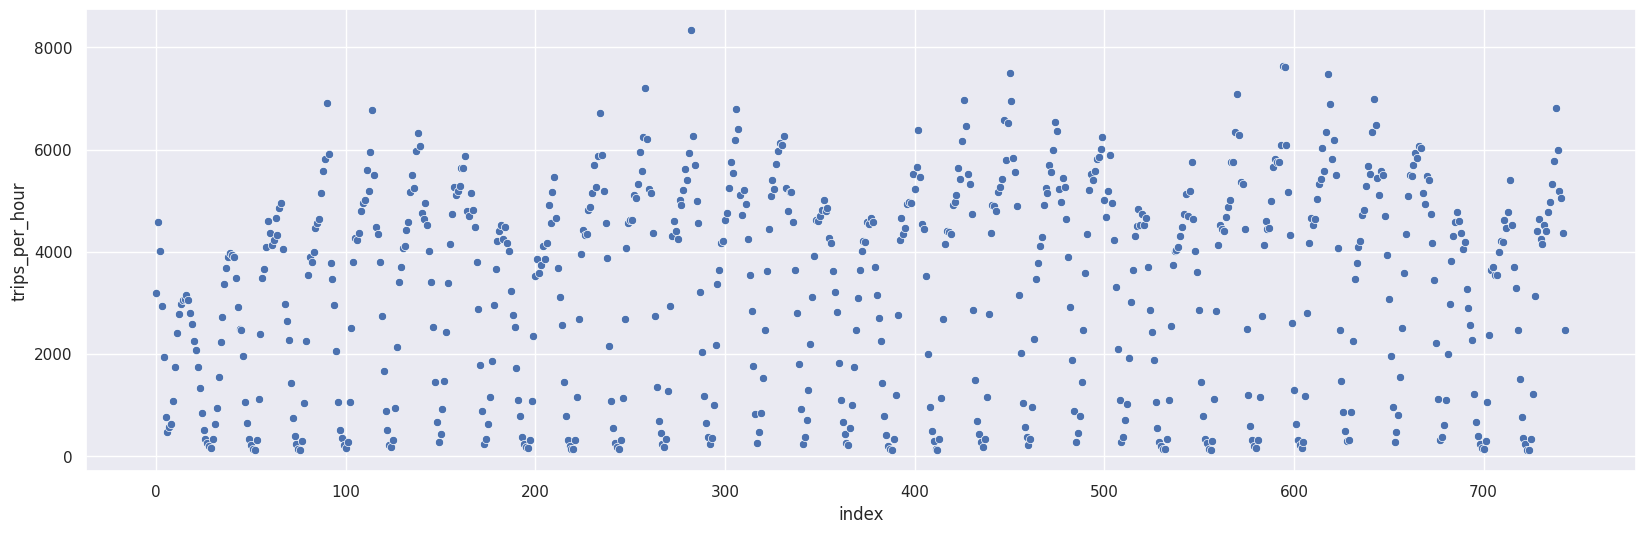

In [ ]:
from datetime import datetime, timedelta
# import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})

# Convert columns to datetime
df_y_MH["pickup_datetime"] = pd.to_datetime(df_y_MH["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")
df_y_MH["dropoff_datetime"] = pd.to_datetime(df_y_MH["dropoff_datetime"], format="%Y-%m-%d %H:%M:%S")

start_date = datetime.strptime("2023-01-01 00:00:05", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-01-31 23:59:59", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=60)
bucket_elements = []
while start_date <= end_date:
    # Check how many trips fall into this interval
    bucket_elements.append(df_y_MH[((start_date + interval) >= df_y_MH["dropoff_datetime"])
                                  & (start_date <= df_y_MH["dropoff_datetime"])].shape[0])
    # Increment
    start_date += interval

sns.scatterplot(x="index", y="trips_per_hour", data=pd.DataFrame(bucket_elements, columns=["trips_per_hour"]).reset_index())

<Axes: xlabel='index', ylabel='trips_per_hour'>

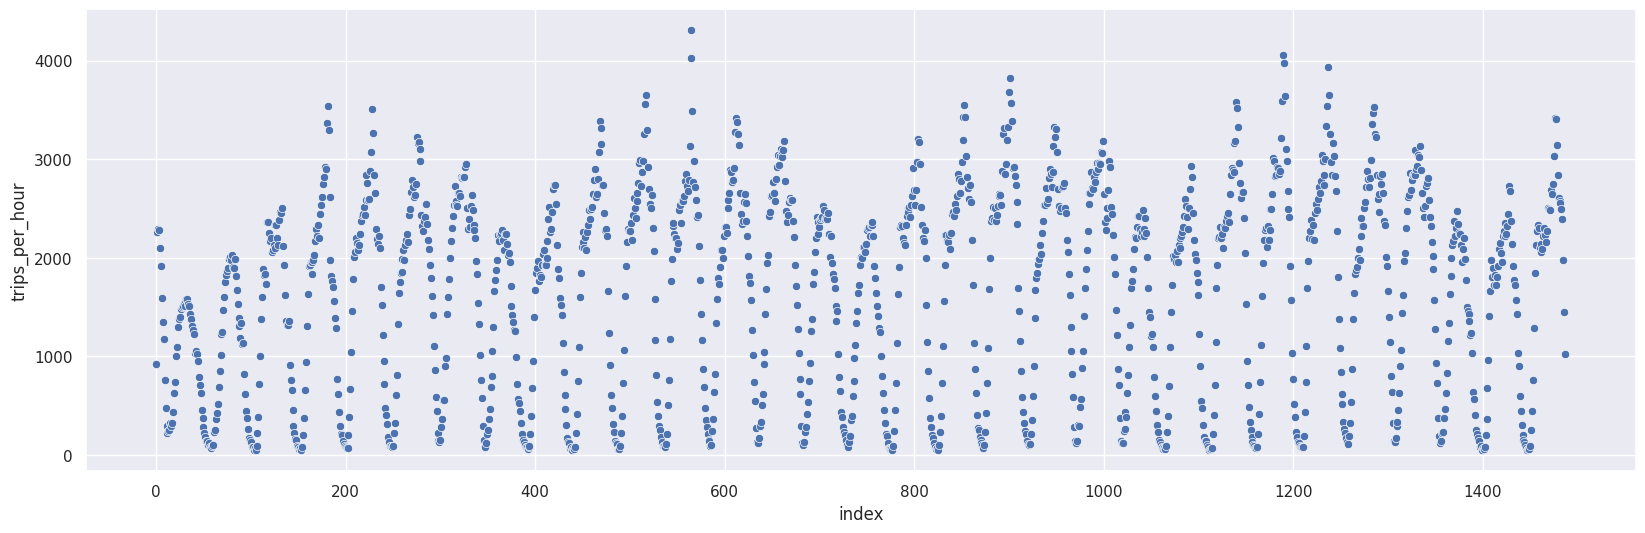

In [ ]:
# here I did 30 min intervals and I think it makes more sense

from datetime import datetime, timedelta
# import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})

# Convert columns to datetime
df_y_MH["pickup_datetime"] = pd.to_datetime(df_y_MH["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")
df_y_MH["dropoff_datetime"] = pd.to_datetime(df_y_MH["dropoff_datetime"], format="%Y-%m-%d %H:%M:%S")

start_date = datetime.strptime("2023-01-01 00:00:05", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-01-31 23:59:59", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=30) #60
bucket_elements = []
while start_date <= end_date:
    # Check how many trips fall into this interval
    bucket_elements.append(df_y_MH[((start_date + interval) >= df_y_MH["dropoff_datetime"])
                                  & (start_date <= df_y_MH["dropoff_datetime"])].shape[0])
    # Increment
    start_date += interval

sns.scatterplot(x="index", y="trips_per_30_min", data=pd.DataFrame(bucket_elements, columns=["trips_per_hour"]).reset_index())

In [ ]:
# we need to figure out the best time interval step
# Another important point is how our graph changes over time. It can happen, that not all nodes are present
# in the next time-step, which makes it a bit difficult as our edge indices are shifted.
# Below I have some hints on how to cope with each of the graph types

# "Static Graph Temporal Signal"

# This is simply a graph that always stays the same and only the label information changes.
# Common examples are road networks (the nodes/edges do not suddently disappear in a long-range time horizon)
# or electricity networks. For this we can either use pytorch geometric temporal or also only pytorch geometric,
# which recently added temporal graph support (but only dynamic edges).
# This is by far the easiest graph type, because the node feature matrix and edge_index stay untouched.
# We only have to adjust the labels in each graph snapshot.

# "Dynamic Graph Temporal/Static Signal"

# The more difficult graph type is a dynamic graph (with regards to nodes/edges). This typically happens in social networks,
# that quickly grow/shrink over time, but also transaction systems like crypto networks. Previously I mentioned
# that the node ordering is implicitly defined by the node feature matrix - but what if this matrix changes.

# Option 1 😸

# The easiest solution is just to append new nodes (in it's temporal order at preprocessing-time) to this matrix and always use
# the full matrix (all nodes) even if not all of them are part of the current snapshot. This matrix can (depending on your nodes) get very big.
# Therefore I suggest to check what your maximum number of nodes is and if it's feasible to store your total node_feature matrix in memory.
# If your node_features change over time, that's also no problem - you can simply update the node feature matrix for each snapshot.
# The important point for this option is that the ordering of the nodes always stays the same! This means index 0 is always the same node
# (e.g. location), even if it's not really used in this snapshot.

# Option 2 😵

# Option 1 will lead to a very big matrix with a lot of redundancies - but has one advantage: You always have the same index for a specific node.
# It can happen that a single node only occurs once and then is carried through all other snapshots, even if it's never used again.
# If you want to make your graph really dynamic, you should also be able to remove nodes. This however will affect the edge_index,
# because the indices of the node_feature matrix change! Therefore we would need to re-index the edge_index to point to the correct nodes.
# But besides this there is another issue.

# In spatio-temporal GNN models, you typically update the node feature embeddings over time (with a recurrent unit).
# The problem really is that you need to update nodes between two snapshots, based on their indices -> But what if a node is not present anymore.
# So as you can see it's not that trivial to learn on a dynamic graph. Therefore I'd suggest to make the first Option work. :)

# In our case we have a Static Graph Temporal Signal, because our locations/edges do not really change over time.
# But as we will see later, when incorporating the labels as edge_features (for historical snapshots), we will end up with a
# Dynamic Graph Temporal Signal.

# Coming back to the node features...

# We don't really have information about the nodes (locations) here but we need them in order to apply message passing.
# If really nothing comes to your mind, I would probably assign random values (gaussian samples) to the node feature matrix.

# Here we can model the 'passenger count' as an attribute for the nodes. This allows us to say
# "this is a heavily frequented location" or not. We can calculate this information based on the dataset, but here it's always
# important to consider that we should apply a train/test split in advance (which I didn't do here) to leak no information into the train set.



In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,2.5
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,2.5


In [ ]:
# I am using 'passenger_count' as a proxy for busy-ness/demand of a route (this is not a good idea on a second thought)
# maybe we should use df_y_MH['PULocationID'].value_counts() [I have this in the following cells, scroll down]
df_y_MH['passenger_count'].value_counts()

1.0    1882221
2.0     364055
3.0      87572
0.0      44180
4.0      43201
5.0      36252
6.0      24196
8.0          5
7.0          1
Name: passenger_count, dtype: int64

In [ ]:
outgoing_trips = df_y_MH.groupby("PULocationID").count()["passenger_count"].values

In [ ]:
incoming_trips = df_y_MH.groupby("DOLocationID").count()['passenger_count'].values

In [ ]:
outgoing_trips

In [ ]:
incoming_trips

In [ ]:
# Normalize features between 0 and 1 (think about using std for normalization?)
outgoing_trips_norm = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips_norm = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

In [ ]:
outgoing_trips_norm

array([8.81559976e-01, 3.35688971e-01, 5.38484485e-01, 4.44547824e-01,
       5.78371698e-01, 4.30335874e-01, 5.34116494e-01, 5.34478718e-01,
       4.88085684e-01, 3.18650255e-01, 1.00000000e+00, 2.26851424e-01,
       2.34607271e-01, 5.55260410e-01, 4.89825778e-01, 4.33773447e-01,
       5.73968195e-01, 2.38257917e-01, 9.32612201e-01, 1.48234693e-01,
       4.08204720e-01, 4.35556155e-01, 6.86903840e-01, 2.58315163e-02,
       6.68607996e-01, 1.70003622e-01, 1.30677500e-01, 1.79400129e-01,
       4.18496133e-01, 2.44714021e-01, 9.74381556e-02, 2.80311370e-01,
       1.22353459e-01, 8.83541553e-02, 7.26499854e-01, 1.53597023e-01,
       3.04012159e-01, 1.17374660e-01, 1.96239977e-02, 8.06835373e-02,
       2.53130393e-01, 5.50792986e-02, 8.78143710e-02, 4.38574686e-02,
       2.59550985e-01, 4.34845913e-01, 3.76286427e-02, 3.97664723e-02,
       1.66622868e-02, 7.82829180e-02, 2.19749000e-02, 1.32460209e-02,
       2.52846296e-02, 1.67617208e-03, 3.17080620e-01, 1.02416955e-02,
      

In [ ]:
incoming_trips_norm

array([7.66833829e-01, 2.51069188e-01, 4.93085557e-01, 4.10408933e-01,
       5.86168219e-01, 3.74848939e-01, 5.89764742e-01, 4.81890744e-01,
       4.23354970e-01, 2.72655566e-01, 9.09254716e-01, 3.22001028e-01,
       2.78618414e-01, 4.74350346e-01, 4.77433081e-01, 4.60941175e-01,
       5.85263661e-01, 3.09076699e-01, 1.00000000e+00, 1.67864302e-01,
       4.56816389e-01, 3.39013959e-01, 5.40448227e-01, 8.19529774e-02,
       5.91016651e-01, 1.92960366e-01, 1.52479575e-01, 1.83075353e-01,
       4.92940827e-01, 2.86375905e-01, 1.37847441e-01, 3.37342335e-01,
       2.53146054e-01, 8.59113243e-02, 4.54298099e-01, 1.94820138e-01,
       3.74552244e-01, 2.15349992e-01, 7.82334339e-02, 1.27043397e-01,
       1.90984811e-01, 7.18146886e-02, 1.33346359e-01, 1.19705621e-01,
       2.52321096e-01, 4.46077474e-01, 1.37391543e-01, 5.65240359e-02,
       8.57521221e-02, 7.46513833e-02, 4.99388519e-02, 4.27458047e-02,
       4.69284820e-02, 3.02556643e-02, 2.60498303e-01, 5.38031247e-02,
      

In [ ]:
# Build node features
node_features_norm = np.stack([outgoing_trips_norm, incoming_trips_norm]).transpose()


In [ ]:
node_features

array([[8.81559976e-01, 7.66833829e-01],
       [3.35688971e-01, 2.51069188e-01],
       [5.38484485e-01, 4.93085557e-01],
       [4.44547824e-01, 4.10408933e-01],
       [5.78371698e-01, 5.86168219e-01],
       [4.30335874e-01, 3.74848939e-01],
       [5.34116494e-01, 5.89764742e-01],
       [5.34478718e-01, 4.81890744e-01],
       [4.88085684e-01, 4.23354970e-01],
       [3.18650255e-01, 2.72655566e-01],
       [1.00000000e+00, 9.09254716e-01],
       [2.26851424e-01, 3.22001028e-01],
       [2.34607271e-01, 2.78618414e-01],
       [5.55260410e-01, 4.74350346e-01],
       [4.89825778e-01, 4.77433081e-01],
       [4.33773447e-01, 4.60941175e-01],
       [5.73968195e-01, 5.85263661e-01],
       [2.38257917e-01, 3.09076699e-01],
       [9.32612201e-01, 1.00000000e+00],
       [1.48234693e-01, 1.67864302e-01],
       [4.08204720e-01, 4.56816389e-01],
       [4.35556155e-01, 3.39013959e-01],
       [6.86903840e-01, 5.40448227e-01],
       [2.58315163e-02, 8.19529774e-02],
       [6.686079

In [ ]:
print("Full shape: ", node_features_norm.shape)


Full shape:  (63, 2)


In [ ]:
node_features_norm[:10] # [num_nodes x num_features]

array([[0.88155998, 0.76683383],
       [0.33568897, 0.25106919],
       [0.53848448, 0.49308556],
       [0.44454782, 0.41040893],
       [0.5783717 , 0.58616822],
       [0.43033587, 0.37484894],
       [0.53411649, 0.58976474],
       [0.53447872, 0.48189074],
       [0.48808568, 0.42335497],
       [0.31865026, 0.27265557]])

In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,2.5
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,2.5


In [ ]:
# Extract the edges

# As mentioned previously, we want to create the edges based on the 'trip_distance', and latitudes, longitudes of the PULocation and
# DOLocations as this is all information we have in this dataset.
# The hope is, that the GNN can later identify "crowded" places, where the tripduration will most likely take longer (due to traffic).

# The topology of our graph is therefore static in this dataset, because the edges don't change and also the nodes are always the same.
# Therefore we can pre-compute this part of the graph. In fact, the only temporal part here are the labels (tripdurations), as we will see further below.

# Therefore, we only calculate the edges once here for all snapshots. This can be efficiently done by building all combinations (the cartesian product)
# and applying the distance calculation on each row. Remember: when dealing with dataframes there is almost always a better way than using a for-loop 😀

# But there was one problem I encountered during modelling the labels. I planned to use past labels (aka historical trip durations) as edge features,
# as this will add a lot of information to the graph. This basically tells us "this is the current trip duration for some parts of the graph
# (edge features), please predict 1 hour into the future for other parts of the graph" (labels). Edge features however can only
# "live" on existing edges and unfortunately the static edges here (based on the location) are different from the taxi-trips
#(which are not distance-based). Because of that I will extend the edge index later by the edges for the taxi trips and will use
# edge features to signal that these added edges have different properties than the once I add here. Consequentely, we will use a
# Dynamic Graph Temporal Signal later. Note that this situation comes from the fact that we have two edges types - one for the distance-based edges
# and one for the trips. We could also model this as a heterogeneous graph instead of providing the information as edge features.

# Edge feats: [distance, edge_type, historical trip duration]




In [ ]:
gpd.read_file("/content/mnt/MyDrive/taxi_colab/assets/tableau/taxi_zones/taxi_zones.dbf")

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,0.003802,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,0.007605,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,0.011407,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,0.015209,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,0.019011,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,0.984791,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,254,Queens,0.965779,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,0.992395,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,0.996198,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [ ]:
gdf = gpd.read_file("/content/mnt/MyDrive/taxi_colab/assets/tableau/taxi_zones/taxi_zones.shp")

In [ ]:
gdf = gdf.to_crs(4326)
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# there is a discussion here
# https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
# regarding the warning I get for centroid

<ipython-input-39-1f9f32507414>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
<ipython-input-39-1f9f32507414>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [ ]:
gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,0.003802,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,0.007605,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,0.011407,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,0.015209,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,0.019011,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188484,40.552659
...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,0.984791,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,254,Queens,0.965779,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",-73.906306,40.744235
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,0.992395,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,0.996198,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",-73.946510,40.775932


In [ ]:

# locations = gpd.read_file("/content/mnt/MyDrive/taxi_colab/assets/tableau/taxi_zones/taxi_zones.shx")
# locations.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,0.003802,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,0.007605,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,0.011407,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,0.015209,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,0.019011,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [ ]:
gdf_MH = gdf[gdf['borough'] == "Manhattan"]

In [ ]:
gdf_MH

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,0.015209,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
11,12,0.036661,0.000042,Battery Park,12,Manhattan,0.045627,"POLYGON ((-74.01566 40.70483, -74.01540 40.704...",-74.015564,40.702946
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,0.049430,"POLYGON ((-74.01244 40.71906, -74.01282 40.717...",-74.016079,40.712038
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,0.091255,"POLYGON ((-73.95954 40.79872, -73.96004 40.798...",-73.965480,40.801970
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,0.155894,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",-73.951292,40.804334
...,...,...,...,...,...,...,...,...,...,...
245,246,0.069467,0.000281,West Chelsea/Hudson Yards,246,Manhattan,0.935361,"POLYGON ((-74.00440 40.76267, -74.00220 40.761...",-74.004015,40.753309
248,249,0.036384,0.000072,West Village,249,Manhattan,0.946768,"POLYGON ((-74.00251 40.72902, -74.00282 40.728...",-74.002875,40.734576
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,0.992395,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,0.996198,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",-73.946510,40.775932


In [ ]:
# drop the followings:
gdf_MH[gdf_MH['LocationID'] == 103]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,0.391635,"POLYGON ((-74.04389 40.69018, -74.04351 40.689...",-74.045288,40.689860
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,0.391635,"POLYGON ((-74.03995 40.70089, -74.03945 40.700...",-74.040771,40.698769
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,0.391635,"POLYGON ((-74.01675 40.69334, -74.01540 40.693...",-74.019073,40.688784


In [ ]:
gdf_MH[gdf_MH['zone'] == "Governor's Island/Ellis Island/Liberty Island"]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,0.391635,"POLYGON ((-74.04389 40.69018, -74.04351 40.689...",-74.045288,40.689860
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,0.391635,"POLYGON ((-74.03995 40.70089, -74.03945 40.700...",-74.040771,40.698769
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,0.391635,"POLYGON ((-74.01675 40.69334, -74.01540 40.693...",-74.019073,40.688784


In [ ]:
gdf_MH[gdf_MH['LocationID'] == 153]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
152,153,0.024737,0.000032,Marble Hill,153,Manhattan,0.581749,"POLYGON ((-73.90667 40.87572, -73.90693 40.875...",-73.910379,40.875968


In [ ]:
gdf_MH[gdf_MH['zone'] == "Marble Hill"]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
152,153,0.024737,0.000032,Marble Hill,153,Manhattan,0.581749,"POLYGON ((-73.90667 40.87572, -73.90693 40.875...",-73.910379,40.875968


In [ ]:
gdf_MH[gdf_MH['LocationID'] == 194]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
193,194,0.081794,0.000273,Randalls Island,194,Manhattan,0.737643,"POLYGON ((-73.91640 40.79768, -73.91545 40.797...",-73.924596,40.791001


In [ ]:
gdf_MH[gdf_MH['zone'] == "Randalls Island"]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
193,194,0.081794,0.000273,Randalls Island,194,Manhattan,0.737643,"POLYGON ((-73.91640 40.79768, -73.91545 40.797...",-73.924596,40.791001


In [ ]:
gdf_MH[gdf_MH['LocationID'] == 202]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
201,202,0.069922,0.000106,Roosevelt Island,202,Manhattan,0.768061,"POLYGON ((-73.94180 40.76905, -73.94257 40.768...",-73.949952,40.7619


In [ ]:
gdf_MH[gdf_MH['zone'] == "Roosevelt Island"]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
201,202,0.069922,0.000106,Roosevelt Island,202,Manhattan,0.768061,"POLYGON ((-73.94180 40.76905, -73.94257 40.768...",-73.949952,40.7619


In [ ]:
# if we drop the above 6 zones, we get to have the 63 zones we kept in the df_y_MH

In [ ]:
gdf_MH = gdf_MH[gdf_MH['LocationID'] != 103] # ,153,194,202]]


In [ ]:
gdf_MH = gdf_MH[gdf_MH['LocationID'] != 153]

In [ ]:
gdf_MH = gdf_MH[gdf_MH['LocationID'] != 202]

In [ ]:
gdf_MH = gdf_MH[gdf_MH['LocationID'] != 194]

In [ ]:
# this GEO data set matches with the taxi zones we have in df_y_MH
gdf_MH

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,0.015209,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
11,12,0.036661,0.000042,Battery Park,12,Manhattan,0.045627,"POLYGON ((-74.01566 40.70483, -74.01540 40.704...",-74.015564,40.702946
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,0.049430,"POLYGON ((-74.01244 40.71906, -74.01282 40.717...",-74.016079,40.712038
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,0.091255,"POLYGON ((-73.95954 40.79872, -73.96004 40.798...",-73.965480,40.801970
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,0.155894,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",-73.951292,40.804334
...,...,...,...,...,...,...,...,...,...,...
245,246,0.069467,0.000281,West Chelsea/Hudson Yards,246,Manhattan,0.935361,"POLYGON ((-74.00440 40.76267, -74.00220 40.761...",-74.004015,40.753309
248,249,0.036384,0.000072,West Village,249,Manhattan,0.946768,"POLYGON ((-74.00251 40.72902, -74.00282 40.728...",-74.002875,40.734576
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,0.992395,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,0.996198,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",-73.946510,40.775932


In [ ]:
df_y_MH['PULocationID'].value_counts()

10    140805
18    131317
0     124129
34    102297
22     96722
       ...  
57       713
53       244
60       107
61        10
62         8
Name: PULocationID, Length: 63, dtype: int64

In [ ]:
# new_ids = list(range(len(df_y_MH['PULocationID'].unique())))
# zip(locations, new_ids)
# dict(zip(locations, new_ids))
# mapping = dict(zip(locations, new_ids))
gdf_MH['LocationID'] = gdf_MH['LocationID'].map(mapping)
gdf_MH.head()

# now, the LocationID numbers match with the df_y_MH PULocation and DOLocation

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
3,4,0.043567,0.000112,Alphabet City,38,Manhattan,0.015209,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
11,12,0.036661,0.000042,Battery Park,57,Manhattan,0.045627,"POLYGON ((-74.01566 40.70483, -74.01540 40.704...",-74.015564,40.702946
12,13,0.050281,0.000149,Battery Park City,30,Manhattan,0.049430,"POLYGON ((-74.01244 40.71906, -74.01282 40.717...",-74.016079,40.712038
23,24,0.047000,0.000061,Bloomingdale,41,Manhattan,0.091255,"POLYGON ((-73.95954 40.79872, -73.96004 40.798...",-73.965480,40.801970
40,41,0.052793,0.000143,Central Harlem,43,Manhattan,0.155894,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",-73.951292,40.804334


In [ ]:
gdf_MH.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63 entries, 3 to 262
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    63 non-null     int64   
 1   Shape_Leng  63 non-null     float64 
 2   Shape_Area  63 non-null     float64 
 3   zone        63 non-null     object  
 4   LocationID  63 non-null     int64   
 5   borough     63 non-null     object  
 6   NormID      63 non-null     float64 
 7   geometry    63 non-null     geometry
 8   lon         63 non-null     float64 
 9   lat         63 non-null     float64 
dtypes: float64(5), geometry(1), int64(2), object(2)
memory usage: 5.4+ KB


In [ ]:
df_y_MH.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.90,2.5
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.30,2.5
3487,2023-01-01 00:00:08,2023-01-01 00:11:24,1.0,3.10,1.0,56,55,2,18.80,0.0
4459,2023-01-01 00:00:09,2023-01-01 00:15:10,1.0,3.80,1.0,8,29,1,32.24,2.5
2305,2023-01-01 00:00:18,2023-01-01 00:09:34,1.0,2.10,1.0,28,31,1,21.30,2.5


In [ ]:
df_y_MH.columns

Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'congestion_surcharge'],
      dtype='object')

In [ ]:
gdf_MH.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'NormID', 'geometry', 'lon', 'lat'],
      dtype='object')

In [ ]:
gdf_MH.head(2)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,NormID,geometry,lon,lat
3,4,0.043567,0.000112,Alphabet City,38,Manhattan,0.015209,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
11,12,0.036661,0.000042,Battery Park,57,Manhattan,0.045627,"POLYGON ((-74.01566 40.70483, -74.01540 40.704...",-74.015564,40.702946


In [ ]:
gdf_MH.drop(columns=['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'borough','NormID', 'geometry' ],axis =1, inplace = True)

In [ ]:
gdf_MH.head(2)

,LocationID,lon,lat
3,38,-73.976968,40.723752
11,57,-74.015564,40.702946


In [ ]:
longitude_dict = gdf_MH.set_index('LocationID')['lon'].to_dict()

In [ ]:
latitude_dict = gdf_MH.set_index('LocationID')['lat'].to_dict()

In [ ]:
df_y_MH['PULocationID_lon'] =  df_y_MH['PULocationID'].map(longitude_dict)

In [ ]:
df_y_MH['PULocationID_lat'] =  df_y_MH['PULocationID'].map(latitude_dict)

In [ ]:
df_y_MH['DOLocationID_lon'] =  df_y_MH['DOLocationID'].map(longitude_dict)

In [ ]:
df_y_MH['DOLocationID_lat'] =  df_y_MH['DOLocationID'].map(latitude_dict)

In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,congestion_surcharge,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,2.5,-74.002875,40.734576,-73.992438,40.748497
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,2.5,-74.007486,40.726290,-73.999917,40.748428


In [ ]:
df_y_MH.drop(columns=['congestion_surcharge'], axis = 1 , inplace = True)
#df[['Name', 'Qualification']]

In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,-74.002875,40.734576,-73.992438,40.748497
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,-74.007486,40.726290,-73.999917,40.748428


In [ ]:
# As mentioned previously, we want to create the edges based on the distances of the locations,
# as this is all information we have in this dataset. The hope is, that the GNN can later identify "crowded" places,
# where the tripduration will most likely take longer (due to traffic).

# The topology of our graph is therefore static in this dataset, because the edges don't change and also the nodes are always the same.
# Therefore we can pre-compute this part of the graph. In fact, the only temporal part here are the labels (tripdurations), as we will
# see further below.

# Therefore, we only calculate the edges once here for all snapshots. This can be efficiently done by building all combinations
 # (the cartesian product) and applying the distance calculation on each row. Remember: when dealing with dataframes there is
 # almost always a better way than using a for-loop 😀

# But there was one problem I encountered during modelling the labels.
# I planned to use past labels (aka historical trip durations) as edge features, as this will add a lot of information to the graph.
# This basically tells us "this is the current trip duration for some parts of the graph (edge features),
# please predict 1 hour into the future for other parts of the graph" (labels). Edge features however can only "live" on existing
# edges and unfortunately the static edges here (based on the location) are different from the bike-trips (which are not distance-based).
# Because of that I will extend the edge index later by the edges for the bike trips and will use edge features to signal that these added edges
# have different properties than the once I add here. Consequentely, we will use a Dynamic Graph Temporal Signal later.
# Note that this situation comes from the fact that we have two edges types - one for the distance-based edges and one for the trips.
# We could also model this as a heterogeneous graph instead of providing the information as edge features.

In [ ]:
df_y_MH.columns

Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'PULocationID_lon', 'PULocationID_lat',
       'DOLocationID_lon', 'DOLocationID_lat'],
      dtype='object')

In [ ]:
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

# Get all possible start locations and their geo info
subset = ["PULocationID_lon", "PULocationID_lat", "PULocationID"]
all_starts = df_y_MH.drop_duplicates(subset="PULocationID", keep="first")[subset]
# Get all possible end locations and their geo info
subset = ["DOLocationID_lon", "DOLocationID_lat", "DOLocationID"]
all_ends = df_y_MH.drop_duplicates(subset="DOLocationID", keep="first")[subset]
# Combine all combinations in one dataframe
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["PULocationID_lat"], x["PULocationID_lon"]),
                                                          (x["DOLocationID_lat"], x["DOLocationID_lon"])).meters, axis=1)
distance_matrix.head()

,DOLocationID_lon,DOLocationID_lat,DOLocationID,PULocationID_lon,PULocationID_lat,PULocationID,distance
0,-73.992438,40.748497,34,-74.002875,40.734576,21,1779.629041
1,-73.992438,40.748497,34,-74.007486,40.726290,33,2774.352758
2,-73.992438,40.748497,34,-73.940772,40.818258,56,8890.099379
3,-73.992438,40.748497,34,-73.985937,40.727620,8,2382.491835
4,-73.992438,40.748497,34,-73.973049,40.791705,28,5069.735170


In [ ]:
distance_matrix.shape

(3969, 7)

In [ ]:
63*63

3969

In [ ]:
# we have trip_distance as a col in miles and it (almost) matches with the distace we got up there in meters.
df_y_MH.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.90,-74.002875,40.734576,-73.992438,40.748497
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.30,-74.007486,40.726290,-73.999917,40.748428
3487,2023-01-01 00:00:08,2023-01-01 00:11:24,1.0,3.10,1.0,56,55,2,18.80,-73.940772,40.818258,-73.941399,40.841709
4459,2023-01-01 00:00:09,2023-01-01 00:15:10,1.0,3.80,1.0,8,29,1,32.24,-73.985937,40.727620,-74.007880,40.717773
2305,2023-01-01 00:00:18,2023-01-01 00:09:34,1.0,2.10,1.0,28,31,1,21.30,-73.973049,40.791705,-73.946510,40.775932


<Axes: xlabel='distance', ylabel='Count'>

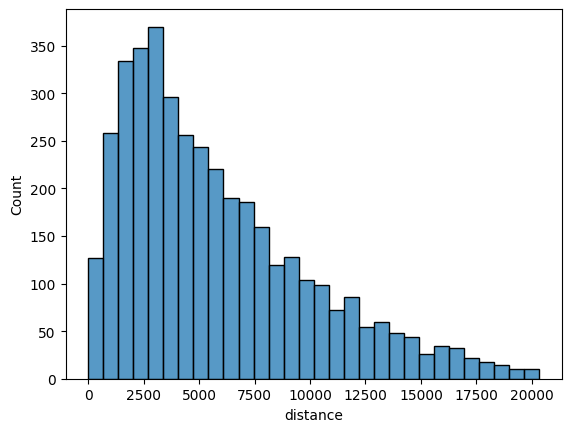

In [ ]:
# to get an idea about the distance and how to bucket it
sns.histplot(data=distance_matrix, x="distance")


In [ ]:
# Based on the new "distance" column we can now create edges. For this we can select a threshold to only connect
# nodes that are close to each other. Alternatively, you can also take all edges and assign a weight to each edge in the graph.

# The distance column is based on meters and here I'll just use 500 meteres as a cutoff (simply plot a histogram to find a good threshold).
# This will also generate self-loops (if you dont want that, simply also add > X).

In [ ]:
# for loop for each point 2,63 by 63 that would be our edge

In [ ]:
distance_matrix["edge"] = distance_matrix["distance"] < 1 #500
distance_matrix.head()

,DOLocationID_lon,DOLocationID_lat,DOLocationID,PULocationID_lon,PULocationID_lat,PULocationID,distance,edge
0,-73.992438,40.748497,34,-74.002875,40.734576,21,1779.629041,False
1,-73.992438,40.748497,34,-74.007486,40.726290,33,2774.352758,False
2,-73.992438,40.748497,34,-73.940772,40.818258,56,8890.099379,False
3,-73.992438,40.748497,34,-73.985937,40.727620,8,2382.491835,False
4,-73.992438,40.748497,34,-73.973049,40.791705,28,5069.735170,False


In [ ]:
# maybe we need to increase the threashold of 500 m? let's do 1 m
distance_matrix.edge.value_counts()

False    3892
True       77
Name: edge, dtype: int64

In [ ]:
# Now we are almost there! We just need a way to build the edge_index. For this, we need to consider the original
# ordering in the node feature matrix. Remember when we did the mapping of the indices before?
# - Because of that we already have the edge indices set.

In [ ]:
# Use mask to extract static edges
edge_index = distance_matrix[distance_matrix["edge"] == True][["PULocationID", "DOLocationID"]].values
edge_index = edge_index.transpose()
edge_index # [2 x num_edges]

array([[34, 14, 55, 29, 15, 31,  3, 56, 44, 40, 27, 20, 15, 31, 39, 52,
        50, 23, 36,  4, 16, 12, 41, 25, 19, 10,  5, 17, 32, 18,  2,  7,
        26,  1, 24, 41, 25, 28,  6, 45,  6, 45, 22,  0, 38, 46,  9, 21,
        22,  0,  8, 13, 37, 49, 30, 51, 35, 11, 43, 47, 57, 39, 52, 59,
        33, 49, 30, 48, 42, 60, 53, 54, 61, 58, 62, 47, 57],
       [34, 14, 55, 29, 31, 31,  3, 56, 44, 40, 27, 20, 15, 15, 52, 52,
        50, 23, 36,  4, 16, 12, 41, 41, 19, 10,  5, 17, 32, 18,  2,  7,
        26,  1, 24, 25, 25, 28, 45, 45,  6,  6,  0,  0, 38, 46,  9, 21,
        22, 22,  8, 13, 37, 30, 30, 51, 35, 11, 43, 47, 47, 39, 39, 59,
        33, 49, 49, 48, 42, 60, 53, 54, 61, 58, 62, 57, 57]])

In [ ]:
edge_index.shape

(2, 77)

In [ ]:
# edge weight, what does it do? is it NN and NNN analogue?

In [ ]:
# Add edge features to indicate edge type
distance_feature = distance_matrix[distance_matrix["edge"] == True]["distance"].values
edge_type_feature = np.zeros_like(distance_feature) # 0 = static edge
trip_duration_feature = np.zeros_like(distance_feature) # 0 = no information
static_edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
static_edge_features # [num_edges x num_features]

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [493.23886622,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [493.23886622,   0.        ,   0.        ],
       [409.94619979,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

In [ ]:
static_edge_features.shape

(77, 3)

In [ ]:
# Now we get in touch with the temporal aspect of our dataset. Because the edge_index and the node features were static,
# we could pre-compute them for each snapshot. The labels however change over time, because we have different trip durations for
# different taxi rides for each 60 min interval. In addition to that we can also use historical labels as edge features. This is a special
# attribute of time-series datasets - the labels become features for past timesteps. If you have a node-level prediction task you can add the
# historical labels as node features to each of the nodes. But this also means that you cannot pre-compute the node feature matrix and need to do
# it in the following loop instead.

# In most of the time-series libraries this is called a "lag" or "offset". In our dataset we want to predict 1 hour into the future,
# based on the current situation (trip durations). Therefore, we can use the current trip durations as edge features and the trip durations of
# the next snapshot as targets. Of course you could also define a larger offset, for example 12 hours into the future.

# As mentioned previously, we have to types of edges now - static edges based on the location and edges for historical trips
# (for which we need to insert new edges to use the edge features). It can happen that we have multiple bikers on the same
# "edge" (=route) - here we simply average all of the trip durations between two nodes.

# Generally, everything that is temporal needs to be computed in a loop over the time-series. Because of that, we loop over the start
# and end time of our dataset and store the labels of each subsequent snapshot in a list and the current trip durations as edge features
# in another list. We also stack the pre-computed node_features and edge_index, so that the first entry in each list corresponds to the
# first snapshot and so on. That's at least how it is typically done in pytorch geometric temporal. Note that there is also a TemporalData Object
# in plain PyG available now.

In [ ]:
df_y_MH.pickup_datetime.min()

'2023-01-01 00:00:05'

In [ ]:
df_y_MH.dropoff_datetime.max()

'2023-02-01 23:18:41'

In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,-74.002875,40.734576,-73.992438,40.748497
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,-74.007486,40.726290,-73.999917,40.748428


In [ ]:
df_y_MH['ride_duration'] = df_y_MH['dropoff_datetime']- df_y_MH['pickup_datetime']

In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat,ride_duration
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,-74.002875,40.734576,-73.992438,40.748497,0 days 00:26:22
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,-74.007486,40.726290,-73.999917,40.748428,0 days 00:05:38


In [ ]:
df_y_MH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2481683 entries, 3485 to 2994400
Data columns (total 14 columns):
 #   Column            Dtype          
---  ------            -----          
 0   pickup_datetime   datetime64[ns] 
 1   dropoff_datetime  datetime64[ns] 
 2   passenger_count   float64        
 3   trip_distance     float64        
 4   RatecodeID        float64        
 5   PULocationID      int64          
 6   DOLocationID      int64          
 7   payment_type      int64          
 8   total_amount      float64        
 9   PULocationID_lon  float64        
 10  PULocationID_lat  float64        
 11  DOLocationID_lon  float64        
 12  DOLocationID_lat  float64        
 13  ride_duration     timedelta64[ns]
dtypes: datetime64[ns](2), float64(8), int64(3), timedelta64[ns](1)
memory usage: 284.0 MB


In [ ]:
# converting the ride_duration to only minutes
df_y_MH['ride_duration_min'] = df_y_MH['ride_duration'].dt.total_seconds()/60


In [ ]:
df_y_MH.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat,ride_duration,ride_duration_min
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.90,-74.002875,40.734576,-73.992438,40.748497,0 days 00:26:22,26.366667
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.30,-74.007486,40.726290,-73.999917,40.748428,0 days 00:05:38,5.633333
3487,2023-01-01 00:00:08,2023-01-01 00:11:24,1.0,3.10,1.0,56,55,2,18.80,-73.940772,40.818258,-73.941399,40.841709,0 days 00:11:16,11.266667
4459,2023-01-01 00:00:09,2023-01-01 00:15:10,1.0,3.80,1.0,8,29,1,32.24,-73.985937,40.727620,-74.007880,40.717773,0 days 00:15:01,15.016667
2305,2023-01-01 00:00:18,2023-01-01 00:09:34,1.0,2.10,1.0,28,31,1,21.30,-73.973049,40.791705,-73.946510,40.775932,0 days 00:09:16,9.266667


In [ ]:
df_y_MH['ride_duration_min'].min(), df_y_MH['ride_duration_min'].max()

(0.0, 2155.5833333333335)

In [ ]:
# let's drop the outliers
df_y_MH = df_y_MH[df_y_MH['ride_duration_min'] !=2155.5833333333335]

In [ ]:
df_y_MH['ride_duration_min'].max()

1881.5166666666667

In [ ]:
df_y_MH = df_y_MH[df_y_MH['ride_duration_min'] !=1881.5166666666667]

In [ ]:
df_y_MH['ride_duration_min'].max()

1620.4333333333334

In [ ]:
df_y_MH = df_y_MH[df_y_MH['ride_duration_min'] !=1620.4333333333334]

In [ ]:
df_y_MH['ride_duration_min'].max()

1444.1666666666667

In [ ]:
df_y_MH = df_y_MH[df_y_MH['ride_duration_min'] !=1444.1666666666667]

In [ ]:
df_y_MH['ride_duration_min'].max()

1439.65

In [ ]:
df_y_MH = df_y_MH[df_y_MH['ride_duration_min'] !=1439.65]

<Axes: xlabel='ride_duration_min', ylabel='Count'>

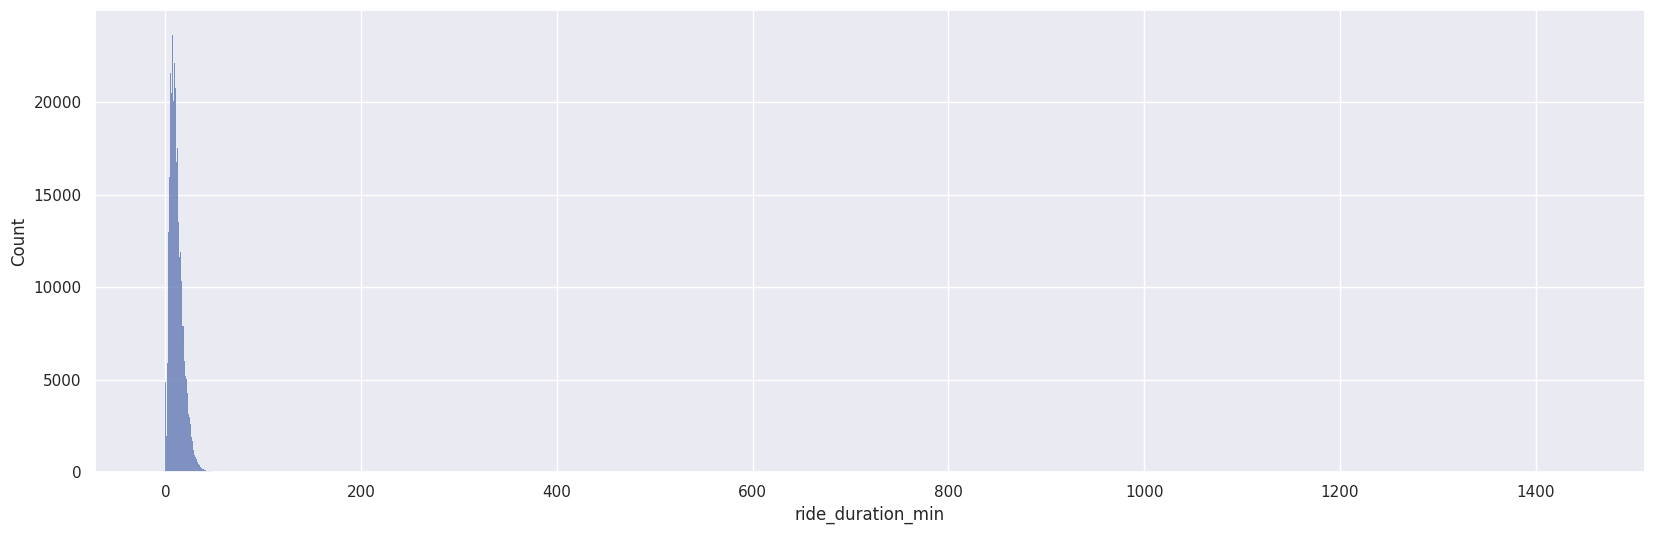

In [ ]:
# to get an idea about the distance and how to bucket it
sns.histplot(data=df_y_MH, x="ride_duration_min")


In [ ]:
df_y_MH['ride_duration_seconds'] = df_y_MH['ride_duration'].dt.total_seconds()


In [ ]:
df_y_MH.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,PULocationID_lon,PULocationID_lat,DOLocationID_lon,DOLocationID_lat,ride_duration,ride_duration_min,ride_duration_seconds
3485,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1.0,21,34,2,26.9,-74.002875,40.734576,-73.992438,40.748497,0 days 00:26:22,26.366667,1582.0
2499,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1.0,33,14,2,14.3,-74.007486,40.726290,-73.999917,40.748428,0 days 00:05:38,5.633333,338.0


In [ ]:
26.366667*60

1582.00002

In [ ]:
def extract_dynamic_edges(s):
    # Extract dynamic edges and their features
    trip_indices = s[["PULocationID", "DOLocationID"]].values
    trip_durations = s["ride_duration_seconds"]

    # Build edge features
    distance_feature  = pd.DataFrame(trip_indices,
                                    columns=["PULocationID", "DOLocationID"]).merge(
                                        distance_matrix, on=["PULocationID", "DOLocationID"],
                                        how="left")["distance"].values
    edge_type_feature = np.ones_like(distance_feature) # 1 = dynamic
    trip_duration_feature = trip_durations
    edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
    return edge_features, trip_indices.transpose()



start_date = datetime.strptime("2023-01-01 00:00:05", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-01-31 23:59:59", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []


while start_date <= end_date:
    # 0 - 60 min
    current_snapshot = df_y_MH[((start_date + interval) >= df_y_MH["dropoff_datetime"])
                                  & (start_date <= df_y_MH["dropoff_datetime"])]
    # 60 - 120 min
    subsequent_snapshot = df_y_MH[((start_date + 2*interval) >= df_y_MH["dropoff_datetime"])
                                  & (start_date + interval <= df_y_MH["dropoff_datetime"])]
    # Average duplicate trips
    current_snapshot = current_snapshot.groupby(["PULocationID", "DOLocationID"]).mean().reset_index()
    subsequent_snapshot = subsequent_snapshot.groupby(["PULocationID", "DOLocationID"]).mean().reset_index()

    # Extract dynamic trip edges
    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    exteneded_edge_index = np.concatenate([edge_index, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)

    # Labels
    y = subsequent_snapshot["ride_duration_seconds"].values
    y_index = subsequent_snapshot[["PULocationID", "DOLocationID"]].values

    # Append everything
    xs.append(node_features) # static
    edge_indices.append(exteneded_edge_index) # static + dynamic
    edge_features.append(extended_edge_feats) # static + dynamic
    ys.append(y) # dynamic
    y_indices.append(y_index.transpose()) # dynamic

    # Increment
    start_date += interval

In [ ]:
# Ok so what did we just do here?

# After each 60 min interval, we get a subset of our dataframe for this time range. Based on that, we extract
# all the available edge labels between two locations. Those are the ones we want to predict later in the model.
# In order to calculate the loss only based on the edges for which we have labels, we store some sort of mask (y_index)
# that tells us for which source/target pairs we have labels.

# Important: Here we take the label of each snapshot as target value.

# We could of course also normalize the labels to ensure smoother training for the regression setup.

In [ ]:
i = 2
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {xs[i].shape} \n
      Edge index shape: {edge_indices[i].shape} \n
      Edge feature shape: {edge_features[i].shape} \n
      Labels shape: {ys[i].shape} \n
      Labels mask shape: {y_indices[i].shape}
      """)

Example of graph snapshot 2: 

      Node feature shape: (63, 2) 

      Edge index shape: (2, 1724) 

      Edge feature shape: (1724, 3) 
 
      Labels shape: (1349,) 

      Labels mask shape: (2, 1349)
      


In [ ]:
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/signal.html
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/wikimath.html#WikiMathsDatasetLoader

In [ ]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
            )

In [ ]:
# End (for now)

In [ ]:
# list of Manhattan zones that we kept: (we kept 63 of the 256 zones)
# [ 4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
#         79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
#        137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
#        164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
#        236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]

In [ ]:
zones = [ 4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
      236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]